In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('final.csv') 


In [3]:
X = data.drop(['MB'], axis=1)  
y = data['MB']  

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Logistic regression layer
])

In [8]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc'),
                  f1_score
                      ]
             )


In [9]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=1
)


Epoch 1/10
368/368 [==============================] - 0s 595us/step - loss: 0.5945 - accuracy: 0.7535 - auc: 0.4038 - f1_score: 0.2869 - val_loss: 0.4736 - val_accuracy: 0.8471 - val_auc: 0.7322 - val_f1_score: 0.2895
Epoch 2/10
368/368 [==============================] - 0s 373us/step - loss: 0.4001 - accuracy: 0.8710 - auc: 0.8659 - f1_score: 0.2873 - val_loss: 0.3501 - val_accuracy: 0.8922 - val_auc: 0.9166 - val_f1_score: 0.2895
Epoch 3/10
368/368 [==============================] - 0s 363us/step - loss: 0.3093 - accuracy: 0.9033 - auc: 0.9409 - f1_score: 0.2868 - val_loss: 0.2859 - val_accuracy: 0.9146 - val_auc: 0.9466 - val_f1_score: 0.2895
Epoch 4/10
368/368 [==============================] - 0s 478us/step - loss: 0.2590 - accuracy: 0.9156 - auc: 0.9581 - f1_score: 0.2872 - val_loss: 0.2476 - val_accuracy: 0.9230 - val_auc: 0.9572 - val_f1_score: 0.2895
Epoch 5/10
368/368 [==============================] - 0s 373us/step - loss: 0.2277 - accuracy: 0.9254 - auc: 0.9651 - f1_score: 

In [10]:
# Get predictions for training
y_train_pred = model.predict(X_train)
y_train_pred_class = tf.round(y_train_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for training
cm_train = confusion_matrix(y_train, y_train_pred_class)
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

print(f"Training Sensitivity: {sensitivity_train:.2f}")
print(f"Training Specificity: {specificity_train:.2f}")

# Get predictions for validation
y_val_pred = model.predict(X_val)
y_val_pred_class = tf.round(y_val_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for validation
cm_val = confusion_matrix(y_val, y_val_pred_class)
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
sensitivity_val = tp_val / (tp_val + fn_val)
specificity_val = tn_val / (tn_val + fp_val)

print(f"Validation Sensitivity: {sensitivity_val:.2f}")
print(f"Validation Specificity: {specificity_val:.2f}")


368/368 [==============================] - 0s 187us/step
Training Sensitivity: 0.78
Training Specificity: 0.98
123/123 [==============================] - 0s 187us/step
Validation Sensitivity: 0.78
Validation Specificity: 0.98


In [11]:
history = model.evaluate(
    X_test, 
    y_test,
)


123/123 [==============================] - 0s 258us/step - loss: 0.1613 - accuracy: 0.9389 - auc: 0.9802 - f1_score: 0.3171


In [12]:
# Get predictions for test data
y_test_pred = model.predict(X_test)
y_test_pred_class = tf.round(y_test_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for test
cm_test = confusion_matrix(y_test, y_test_pred_class)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

print(f"Test Sensitivity: {sensitivity_test:.2f}")
print(f"Test Specificity: {specificity_test:.2f}")


123/123 [==============================] - 0s 191us/step
Test Sensitivity: 0.77
Test Specificity: 0.98


In [13]:
import shap


In [14]:
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/3925 [00:00<?, ?it/s]

664/664 [==============================] - 0s 373us/step


In [15]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(3925, 38)


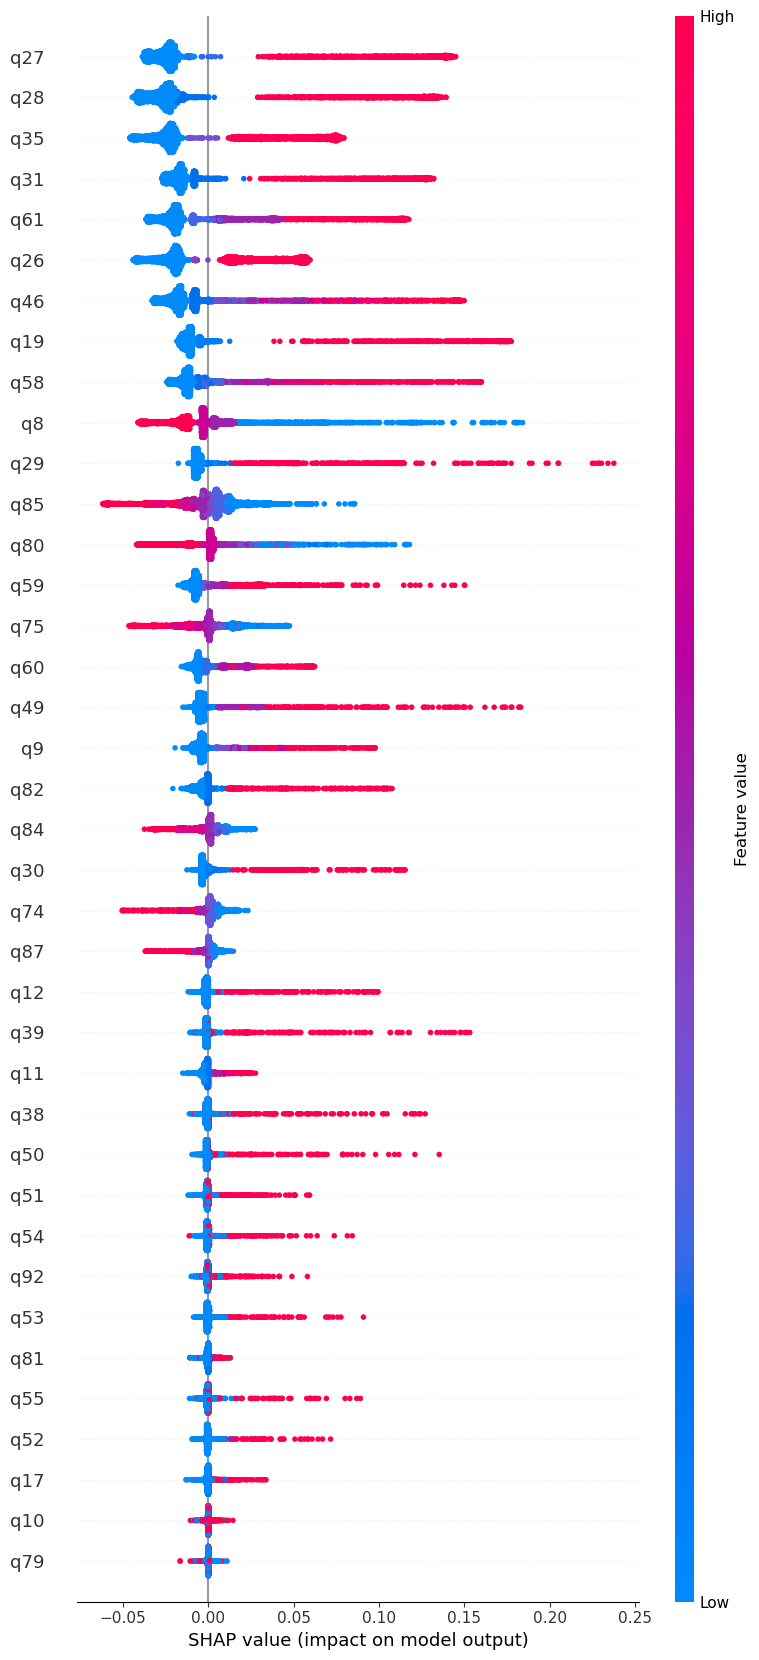

In [16]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])